Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [0]:
!git clone https://github.com/google-research/google-research.git

Cloning into 'google-research'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 15438 (delta 50), reused 89 (delta 20), pack-reused 15319
Receiving objects: 100% (15438/15438), 294.78 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (7310/7310), done.
Checking out files: 100% (5519/5519), done.


In [0]:
import sys
import os
sys.path.append('./google-research')

# Examples of streaming and non streaming inference with TF/TFlite

## Imports

In [0]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.layers.modes import Modes


In [0]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models.utils_test import Flags, _HOTWORD_MODEL_PARAMS
from kws_streaming.train import model_flags
from kws_streaming.train import test
from kws_streaming.models import utils
from kws_streaming.models import utils_test
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
from kws_streaming.layers.gru import GRU
disable_eager_execution()

In [0]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav

In [0]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

## Load wav file

In [0]:
import scipy.signal

In [0]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  file_handle = tf.io.gfile.GFile(filename, 'rb')
  try:
    samplerate, wave_data = wav.read(file_handle)
  finally:
    file_handle.close()  
  # Read in wav file.  
  return wave_data, samplerate  

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
          round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [0]:
# Set path to wav file for testing.
wav_file = "/data2/cat/004ae714_nohash_0.wav"


In [0]:
#wav_data, samplerate = wavread_as_float(wav_file)

# just generate cos
samplerate = 16000
wav_data = np.cos(2.0*np.pi*8.0*np.arange(samplerate)/samplerate)

In [0]:
#assert samplerate == 16000
#sound.Play(wav_data, samplerate)

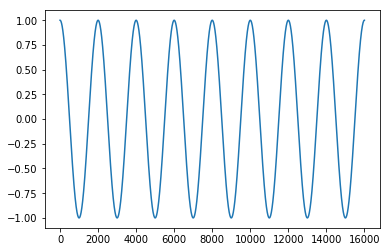

In [0]:
plt.plot(wav_data)

In [0]:
input_data = np.expand_dims(wav_data, 0)
input_data.shape

(1, 16000)

## Prepare batched model

In [0]:
# Set path to model weights and model parameters
# train_dir = "../data2/models/svdf/"

In [0]:
# load command line command flags which were use for model creation/training
# from argparse import Namespace
# with tf.io.gfile.Open(os.path.join(train_dir, 'flags.txt'), 'rt') as fd:
#   flags_txt = fd.read()
# flags = eval(flags_txt)

In [0]:
# with tf.io.gfile.Open(os.path.join(train_dir, 'flags.json'), 'rt') as fd:
#   flags_json = json.load(fd)

# class DictStruct(object):
#   def __init__(self, **entries):
#     self.__dict__.update(entries)

# flags = DictStruct(**flags_json)


In [0]:
flags = _HOTWORD_MODEL_PARAMS['gru']
flags = model_flags.update_flags(flags)

In [0]:
# create model with flag's parameters 
model_non_stream_batch = models.MODELS[flags.model_name](flags)

# load model's weights
# weights_name = 'best_weights'
# model_non_stream_batch.load_weights(os.path.join(train_dir, weights_name))

In [0]:
#model_non_stream_batch.summary()

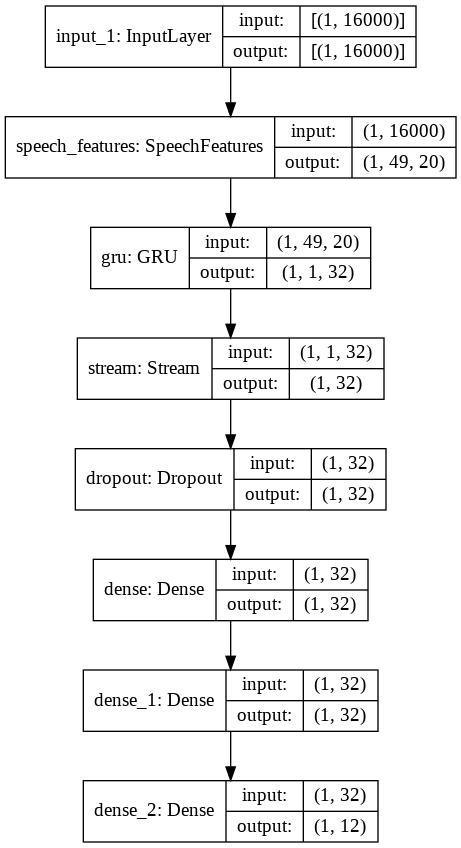

In [0]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

## Run inference with TF

### TF Run non streaming inference

In [0]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
#model_non_stream.summary()

W0410 05:51:11.069287 139995839920000 stream.py:94] There is no need to use Stream on time dim with size 1


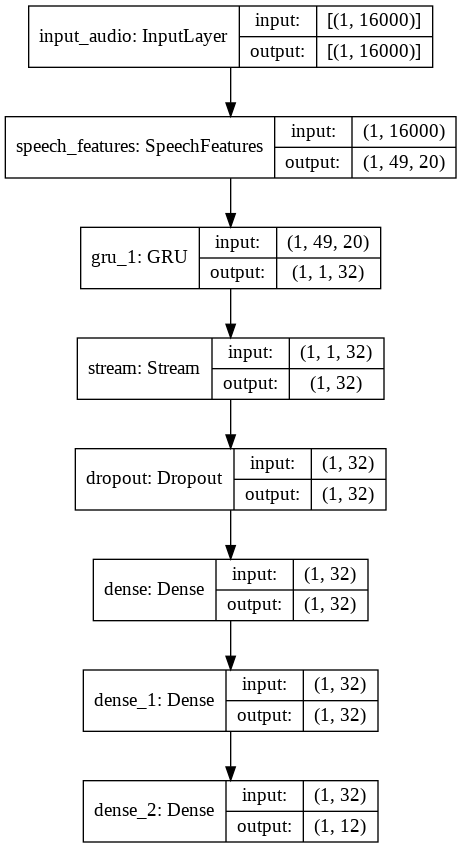

In [0]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [0]:
predictions = model_non_stream.predict(input_data)
predicted_labels = np.argmax(predictions, axis=1)

In [0]:
predicted_labels

array([3])

### TF Run streaming inference with internal state

In [0]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
#model_stream.summary()

W0410 05:58:51.480242 139995839920000 stream.py:94] There is no need to use Stream on time dim with size 1


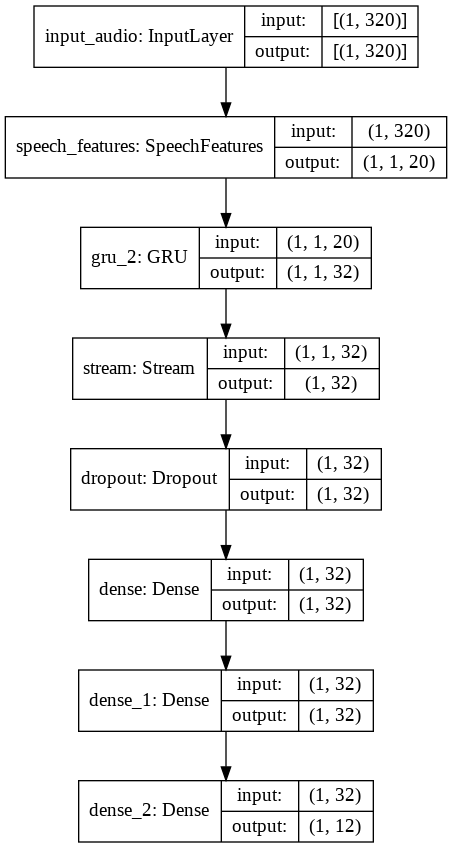

In [0]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [0]:
# run streaming inference
start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]

  # get new frame from stream of data
  stream_output_prediction = model_stream.predict(stream_update)
  stream_output_arg = np.argmax(stream_output_prediction)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

stream_output_arg

3

### TF Run streaming inference with external state

In [0]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
#model_stream.summary()

W0410 05:58:59.740967 139995839920000 stream.py:94] There is no need to use Stream on time dim with size 1


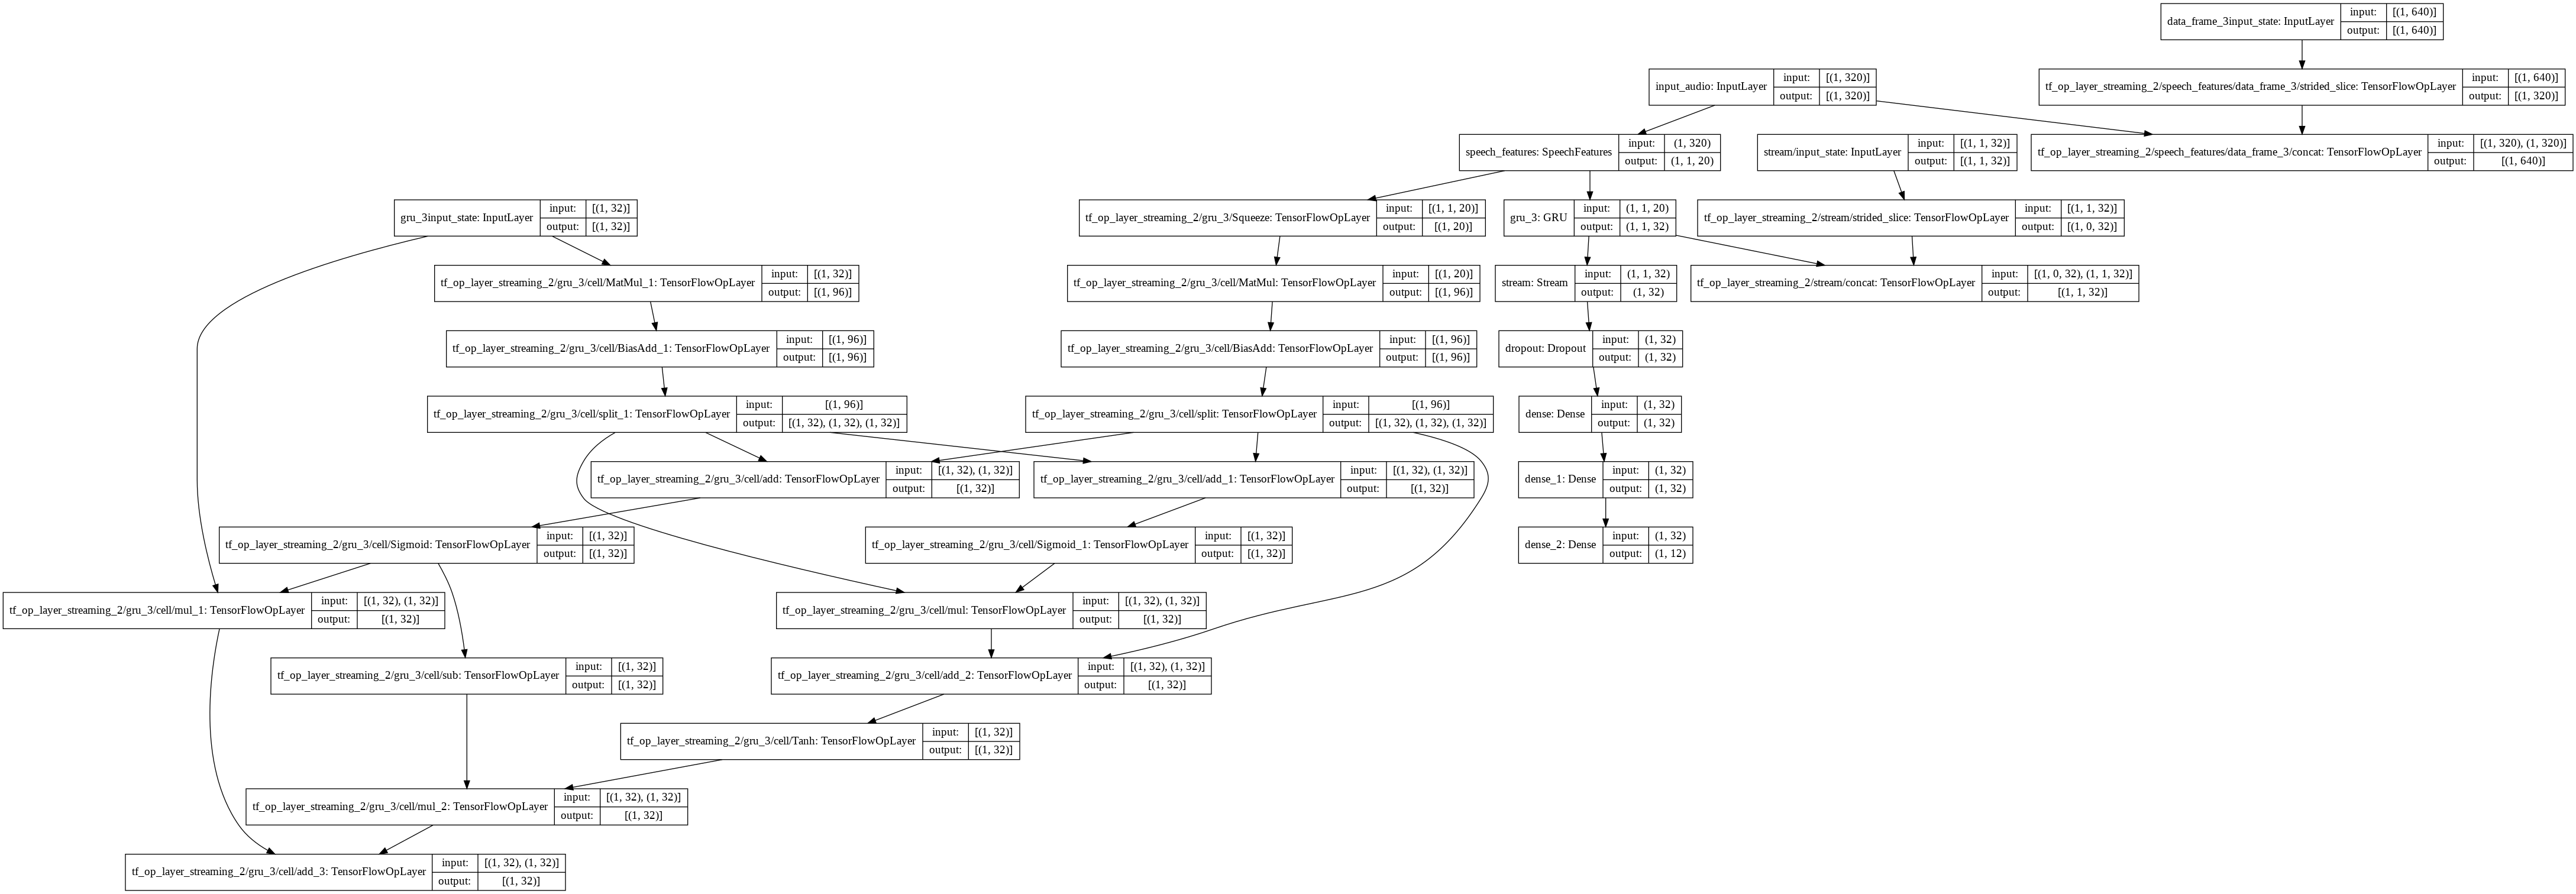

In [0]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [0]:

inputs = []
for s in range(len(model_stream.inputs)):
  inputs.append(np.zeros(model_stream.inputs[s].shape, dtype=np.float32))

reset_state = True

if reset_state:
  for s in range(len(model_stream.inputs)):
    inputs[s] = np.zeros(model_stream.inputs[s].shape, dtype=np.float32)

start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  # get new frame from stream of data
  stream_update = input_data[:, start:end]

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

  # set input audio data (by default input data at index 0)
  inputs[0] = stream_update

  # run inference
  outputs = model_stream.predict(inputs)

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(model_stream.inputs)):
    inputs[s] = outputs[s]

  stream_output_arg = np.argmax(outputs[0])
stream_output_arg

3

##Run inference with TFlite

### Run non streaming inference with TFLite

In [0]:
# path = os.path.join(train_dir, 'tflite_non_stream')
# tflite_model_name = 'non_stream.tflite'

tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.NON_STREAM_INFERENCE)

W0410 05:59:16.283101 139995839920000 stream.py:94] There is no need to use Stream on time dim with size 1
W0410 05:59:18.005902 139995839920000 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/util.py:267: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0410 05:59:18.007421 139995839920000 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/framework/graph_util_impl.py:277: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [0]:
# prepare TFLite interpreter
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_non_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [0]:
padded_input = np.zeros((1, 16000), dtype=np.float32)
padded_input[:, :input_data.shape[1]] = input_data

In [0]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], padded_input.astype(np.float32))

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

3

In [0]:
print(out_tflite)

[[ 0.45560205  0.1924167  -0.47654146  0.82592267  0.37473828  0.03390691
   0.20837061  0.80141175 -0.7983539   0.46959174  0.2718569  -1.1427746 ]]


### Run streaming inference with TFLite

In [0]:
# path = os.path.join(train_dir, 'tflite_stream_state_external')
# tflite_model_name = 'stream_state_external.tflite'

tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)

W0410 06:14:00.503751 139995839920000 stream.py:94] There is no need to use Stream on time dim with size 1


In [0]:
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [0]:
input_details[0]['shape']

array([  1, 320], dtype=int32)

In [0]:
reset_state = True

# before processing new test sequence we can reset model state
# if we reset model state then it is not real streaming mode
if reset_state:
  for s in range(len(input_details)):
    print(input_details[s]['shape'])
    inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]
  stream_update = stream_update.astype(np.float32)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

  # set input audio data (by default input data at index 0)
  interpreter.set_tensor(input_details[0]['index'], stream_update)

  # set input states (index 1...)
  for s in range(1, len(input_details)):
    interpreter.set_tensor(input_details[s]['index'], inputs[s])

  # run inference
  interpreter.invoke()

  # get output: classification
  out_tflite = interpreter.get_tensor(output_details[0]['index'])
  #print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(input_details)):
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    inputs[s] = interpreter.get_tensor(output_details[s]['index'])

  out_tflite_argmax = np.argmax(out_tflite)
out_tflite_argmax  

[  1 320]
[  1 640]
[ 1 32]
[ 1  1 32]


3

In [0]:
print(out_tflite)

[[ 0.9359149  -0.19763303 -0.7887183   1.2777497   0.42338336 -0.30960965
  -0.17484392  0.9523007  -0.5982152  -0.06665994  0.4247468  -1.2773693 ]]


In [0]:
out_tflite_argmax

3